# Hotel Booking Cancellation Prediction

## Introduction
This notebook demonstrates a complete end-to-end machine learning pipeline for predicting hotel booking cancellations. The dataset contains various features related to hotel bookings, such as the number of adults, children, nights stayed, meal types, and booking status. The goal is to predict whether a booking will be canceled (`booking_status`).

### Key Steps Covered:
1. **Data Preprocessing**: Cleaning and transforming the dataset for analysis.
2. **Feature Engineering**: Creating new features and encoding categorical variables.
3. **Model Training**: Training two machine learning models:
   - Polynomial Logistic Regression
   - Random Forest Classifier
4. **Model Evaluation**: Evaluating the models using metrics like accuracy, F1-score, and ROC-AUC.
5. **Visualization**: Visualizing overfitting and model performance.
6. **Model Saving**: Saving the trained models for future use.

This notebook is designed to be a learning resource for anyone interested in machine learning, covering both theoretical and practical aspects.


In [21]:
# Import necessary libraries
# These libraries are used for data manipulation, visualization, and machine learning tasks.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_curve, precision_recall_curve, auc, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
# The dataset is loaded into a pandas DataFrame for further processing.
df = pd.read_csv("first inten project.csv")

# Display dataset information
# This provides an overview of the dataset, including column names, data types, and missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

### Step 1: Rename Columns for Clarity
Renaming columns to make them more descriptive and easier to work with.

In [22]:
# Step 3: Rename columns for clarity
df.rename(columns={
    "number of adults": "adults",
    "number of children": "children",
    "number of weekend nights": "weekend_nights",
    "number of week nights": "week_nights",
    "type of meal": "meal_type",
    "car parking space": "car_parking",
    "room type": "room_type",
    "lead time": "lead_time",
    "market segment type": "market_type",
    "repeated": "is_repeated",
    "P-C": "cancelled_times",
    "P-not-C": "not_cancelled_times",
    "average price": "avg_price",
    "special requests": "special_requests",
    "date of reservation": "reservation_date",
    "booking status": "booking_status"
}, inplace=True)

df.columns[-17:]

Index(['Booking_ID', 'adults', 'children', 'weekend_nights', 'week_nights',
       'meal_type', 'car_parking', 'room_type', 'lead_time', 'market_type',
       'is_repeated', 'cancelled_times', 'not_cancelled_times', 'avg_price',
       'special_requests', 'reservation_date', 'booking_status'],
      dtype='object')

### Step 2: Convert `reservation_date` to Datetime
Converting the `reservation_date` column to a datetime format for easier manipulation and analysis.

In [23]:
# Step 2: Convert reservation_date to datetime
df["reservation_date"]= pd.to_datetime(df["reservation_date"], errors='coerce')
df.head()


,Booking_ID,adults,children,weekend_nights,week_nights,meal_type,car_parking,room_type,lead_time,market_type,is_repeated,cancelled_times,not_cancelled_times,avg_price,special_requests,reservation_date,booking_status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,2015-10-02,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,2018-11-06,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2018-02-28,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,2017-05-20,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,2018-04-11,Canceled


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Booking_ID           36285 non-null  object        
 1   adults               36285 non-null  int64         
 2   children             36285 non-null  int64         
 3   weekend_nights       36285 non-null  int64         
 4   week_nights          36285 non-null  int64         
 5   meal_type            36285 non-null  object        
 6   car_parking          36285 non-null  int64         
 7   room_type            36285 non-null  object        
 8   lead_time            36285 non-null  int64         
 9   market_type          36285 non-null  object        
 10  is_repeated          36285 non-null  int64         
 11  cancelled_times      36285 non-null  int64         
 12  not_cancelled_times  36285 non-null  int64         
 13  avg_price            36285 non-

### Step 3: Feature Engineering - Extract Total Nights
Creating a new feature `total_nights` by summing up `week_nights` and `weekend_nights`.

In [25]:
# Extract total_nights
df["total_nights"] = df["week_nights"] + df["weekend_nights"]
df.head()

,Booking_ID,adults,children,weekend_nights,week_nights,meal_type,car_parking,room_type,lead_time,market_type,is_repeated,cancelled_times,not_cancelled_times,avg_price,special_requests,reservation_date,booking_status,total_nights
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,2015-10-02,Not_Canceled,7
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,2018-11-06,Not_Canceled,4
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2018-02-28,Canceled,4
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,2017-05-20,Canceled,2
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,2018-04-11,Canceled,3


### Step 4: Drop Unnecessary Columns
Removing columns that are not relevant for the analysis.

In [26]:
# Step 1: Drop unnecessary columns
df.drop(columns=["Booking_ID" , "week_nights"], inplace=True)

df.head()

,adults,children,weekend_nights,meal_type,car_parking,room_type,lead_time,market_type,is_repeated,cancelled_times,not_cancelled_times,avg_price,special_requests,reservation_date,booking_status,total_nights
0,1,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,2015-10-02,Not_Canceled,7
1,1,0,1,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,2018-11-06,Not_Canceled,4
2,2,1,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2018-02-28,Canceled,4
3,1,0,0,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,2017-05-20,Canceled,2
4,1,0,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,2018-04-11,Canceled,3


### Step 5: Encode Target Column
Encoding the target column `booking_status` to numerical values for machine learning models.
- `Canceled` → 1
- `Not_Canceled` → 0

In [27]:
# Encode the target column (booking status: 1 = Canceled, 0 = Not Canceled)
df["booking_status"] = df["booking_status"].map({"Canceled": 1, "Not_Canceled": 0})
df.head()

,adults,children,weekend_nights,meal_type,car_parking,room_type,lead_time,market_type,is_repeated,cancelled_times,not_cancelled_times,avg_price,special_requests,reservation_date,booking_status,total_nights
0,1,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,2015-10-02,0,7
1,1,0,1,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,2018-11-06,0,4
2,2,1,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2018-02-28,1,4
3,1,0,0,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,2017-05-20,1,2
4,1,0,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,2018-04-11,1,3


### Step 6: Encode Categorical Columns
Using one-hot encoding for categorical columns like `meal_type`, `room_type`, and `market_type`.

In [28]:
# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df, columns=["meal_type", "room_type", "market_type"])

# Display the last 16 columns to verify the encoding
df_encoded.columns[-16:]

Index(['meal_type_Meal Plan 1', 'meal_type_Meal Plan 2',
       'meal_type_Meal Plan 3', 'meal_type_Not Selected',
       'room_type_Room_Type 1', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'market_type_Aviation',
       'market_type_Complementary', 'market_type_Corporate',
       'market_type_Offline', 'market_type_Online'],
      dtype='object')

In [29]:
df_encoded.head()

,adults,children,weekend_nights,car_parking,lead_time,is_repeated,cancelled_times,not_cancelled_times,avg_price,special_requests,...,room_type_Room_Type 3,room_type_Room_Type 4,room_type_Room_Type 5,room_type_Room_Type 6,room_type_Room_Type 7,market_type_Aviation,market_type_Complementary,market_type_Corporate,market_type_Offline,market_type_Online
0,1,1,2,0,224,0,0,0,88.00,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,1,0,5,0,0,0,106.68,1,...,False,False,False,False,False,False,False,False,False,True
2,2,1,1,0,1,0,0,0,50.00,0,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,211,0,0,0,100.00,1,...,False,False,False,False,False,False,False,False,False,True
4,1,0,1,0,48,0,0,0,77.00,0,...,False,False,False,False,False,False,False,False,False,True


## Models Train

### Split the Data
Splitting the data into training and testing sets based on the year of reservation.

In [30]:
# Drop rows with missing reservation_date
df_encoded_clean = df_encoded.dropna(subset=['reservation_date'])

# Add log-transformed features for lead_time and special_requests
df_encoded_clean["lead_time_log"] = np.log1p(df_encoded_clean["lead_time"])
df_encoded_clean["special_requests_log"] = np.log1p(df_encoded_clean["special_requests"])

df_encoded_clean.drop(columns=["lead_time", "special_requests"], inplace=True)

# Extract year from reservation_date
df_encoded_clean['year'] = df_encoded_clean['reservation_date'].dt.year

# Split data by year and combine subsets
train_list = []
test_list = []

for year, group in df_encoded_clean.groupby('year'):
    train = group.sample(frac=0.8, random_state=42)
    test = group.drop(train.index)
    train_list.append(train)
    test_list.append(test)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)

# Display the shapes of training and testing datasets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)



Training data shape: (28999, 30)
Testing data shape: (7249, 30)


C:\Users\koky3\AppData\Local\Temp\ipykernel_7428\1184148463.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_clean["lead_time_log"] = np.log1p(df_encoded_clean["lead_time"])
C:\Users\koky3\AppData\Local\Temp\ipykernel_7428\1184148463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_clean["special_requests_log"] = np.log1p(df_encoded_clean["special_requests"])
C:\Users\koky3\AppData\Local\Temp\ipykernel_7428\1184148463.py:8: SettingWithCopyWarning: 
A value is trying to be set on 

### Define Features and Target
Separating the features (`X`) and target (`y`) for training and testing.

In [31]:
# Define features and target
target_col = "booking_status"
drop_cols = [target_col, 'reservation_date', 'year' ,]  # Columns to exclude from features

X_train = train_data.drop(columns=drop_cols)
X_test = test_data.drop(columns=drop_cols)
y_train = train_data[target_col]
y_test = test_data[target_col]

df_encoded_clean.columns[-31:]


Index(['adults', 'children', 'weekend_nights', 'car_parking', 'is_repeated',
       'cancelled_times', 'not_cancelled_times', 'avg_price',
       'reservation_date', 'booking_status', 'total_nights',
       'meal_type_Meal Plan 1', 'meal_type_Meal Plan 2',
       'meal_type_Meal Plan 3', 'meal_type_Not Selected',
       'room_type_Room_Type 1', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'market_type_Aviation',
       'market_type_Complementary', 'market_type_Corporate',
       'market_type_Offline', 'market_type_Online', 'lead_time_log',
       'special_requests_log', 'year'],
      dtype='object')

### Polynomial logistic regression
Building a pipeline with polynomial features, scaling, and logistic regression.

In [32]:

# Define the degree of polynomial features
poly_degree = 3  # Higher degrees can lead to overfitting

# Build the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on training and testing sets
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("=== Training Set ===")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

print("=== Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))




=== Training Set ===
Accuracy: 0.8448567191972137
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     19492
           1       0.79      0.71      0.75      9507

    accuracy                           0.84     28999
   macro avg       0.83      0.81      0.82     28999
weighted avg       0.84      0.84      0.84     28999

=== Test Set ===
Accuracy: 0.829907573458408
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      4874
           1       0.76      0.70      0.73      2375

    accuracy                           0.83      7249
   macro avg       0.81      0.80      0.80      7249
weighted avg       0.83      0.83      0.83      7249



In [33]:
# 13. Save the model
dump(pipeline, 'hotel_booking_polynomial_logistic_model.joblib')

['hotel_booking_polynomial_logistic_model.joblib']

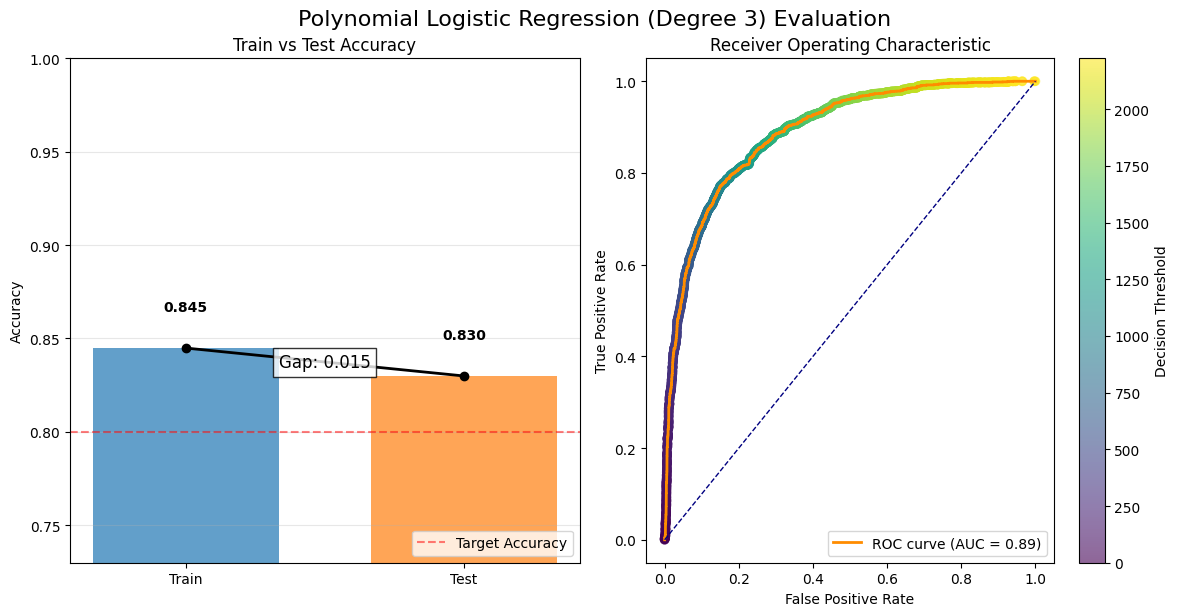

In [34]:
# 13. 🎨 Visualize overfitting

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

# 13.1. Performance Comparison Plot (Enhanced)
plt.figure(figsize=(12, 6))

# Accuracy bars
plt.subplot(1, 2, 1)
positions = [0, 0.3]
plt.bar(positions, [train_acc, test_acc], width=0.2, 
        color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target Accuracy')

# Add exact values
for i, acc in enumerate([train_acc, test_acc]):
    plt.text(positions[i], acc + 0.02, f'{acc:.3f}', 
             ha='center', fontweight='bold')

# Gap visualization (overfitting indicator)
plt.plot(positions, [train_acc, test_acc], 'ko-', linewidth=2)
plt.text(0.15, (train_acc + test_acc)/2, 
         f'Gap: {abs(train_acc - test_acc):.3f}', 
         ha='center', va='center', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.xticks(positions, ['Train', 'Test'])
plt.ylim(min(train_acc, test_acc) - 0.1, 1.0)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

# 14.2. ROC Curve with AUC (Diagnostic Plot)
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.scatter(fpr, tpr, c=np.arange(len(fpr)), cmap='viridis', alpha=0.6)
plt.colorbar(label='Decision Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.tight_layout()
plt.suptitle(f'Polynomial Logistic Regression (Degree {poly_degree}) Evaluation', 
             fontsize=16, y=1.02)
plt.show()

### Random Forest

In [35]:
X_train_resampled = X_train
y_train_resampled = y_train

# Hyperparameter Tuning with GridSearchCV for Random Forest
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20 , 30],
    'rf__min_samples_split': [2, 5 , 10, 20],
    'rf__min_samples_leaf': [1, 5, 10],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__class_weight': ['balanced']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_


Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__max_features': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [36]:
# Predict probabilities to adjust threshold
y_proba_test = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)
best_thresh = 0.5
best_f1 = 0

for t in thresholds:
    preds = (y_proba_test >= t).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1 Score: {best_f1:.4f}")
y_pred_test_thresh = (y_proba_test >= best_thresh).astype(int)

# Train set evaluation
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train_thresh = (y_proba_train >= best_thresh).astype(int)

train_acc = accuracy_score(y_train, y_pred_train_thresh)
test_acc = accuracy_score(y_test, y_pred_test_thresh)

print("=== Training Set ===")
print("Accuracy:", accuracy_score(y_train, y_pred_train_thresh))
print("Classification Report:\n", classification_report(y_train, y_pred_train_thresh))

print("=== Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_test_thresh))

Best threshold: 0.5500000000000002, F1 Score: 0.8239
=== Training Set ===
Accuracy: 0.9751370736921963
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     19492
           1       0.96      0.96      0.96      9507

    accuracy                           0.98     28999
   macro avg       0.97      0.97      0.97     28999
weighted avg       0.98      0.98      0.98     28999

=== Test Set ===
Accuracy: 0.8885363498413574
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      4874
           1       0.85      0.80      0.82      2375

    accuracy                           0.89      7249
   macro avg       0.88      0.86      0.87      7249
weighted avg       0.89      0.89      0.89      7249



In [37]:
dump(best_model, 'hotel_booking_random_forest_model.joblib')

['hotel_booking_random_forest_model.joblib']

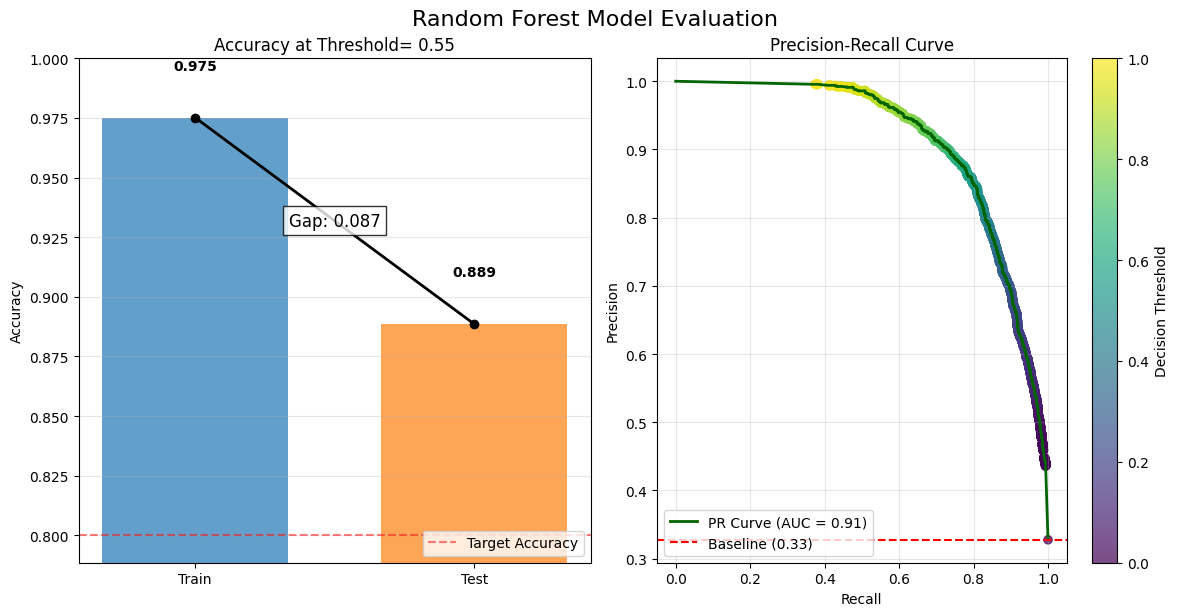

In [38]:
# Visualize overfitting
# Create the dual visualization
plt.figure(figsize=(12, 6))

# Enhanced Accuracy Comparison (Left)
plt.subplot(1, 2, 1)
positions = [0, 0.3]
plt.bar(positions, [train_acc, test_acc], width=0.2, 
        color=['#1f77b4', '#ff7f0e'], alpha=0.7)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target Accuracy')

# Add exact values
for i, acc in enumerate([train_acc, test_acc]):
    plt.text(positions[i], acc + 0.02, f'{acc:.3f}', 
             ha='center', fontweight='bold')

# Gap visualization
plt.plot(positions, [train_acc, test_acc], 'ko-', linewidth=2)
plt.text(0.15, (train_acc + test_acc)/2, 
         f'Gap: {abs(train_acc - test_acc):.3f}', 
         ha='center', va='center', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.xticks(positions, ['Train', 'Test'])
plt.ylim(min(train_acc, test_acc) - 0.1, 1.0)
plt.ylabel('Accuracy')
plt.title('Accuracy at Threshold= {:.2f}'.format(best_thresh))
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

# Enhanced Precision-Recall Curve (Right)
plt.subplot(1, 2, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recall, precision)

# Plot main curve
plt.plot(recall, precision, color='darkgreen', lw=2, 
         label=f'PR Curve (AUC = {pr_auc:.2f})')

# Add threshold markers
sc = plt.scatter(recall[:-1], precision[:-1], c=thresholds, 
                 cmap='viridis', alpha=0.7, marker='o')
plt.colorbar(sc, label='Decision Threshold')

# Add baseline
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, color='r', linestyle='--', 
            label=f'Baseline ({baseline:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

# Overall title
plt.tight_layout()
plt.suptitle('Random Forest Model Evaluation', fontsize=16, y=1.02)
plt.show()

## Conclusion

In this notebook, we successfully built and evaluated two machine learning models to predict hotel booking cancellations. The key takeaways are:
- **Data Preprocessing**: Proper data cleaning and feature engineering are crucial for model performance.
- **Model Comparison**: Polynomial Logistic Regression and Random Forest were used, each with its strengths and weaknesses.
- **Evaluation**: Metrics like accuracy, F1-score, and ROC-AUC were used to assess model performance.
- **Visualization**: Visualizations helped identify overfitting and understand model behavior.
